# Co-variance in abundance

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os,sys
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import scipy.sparse
import anndata
import seaborn as sns

import milopy.core as milo
import milopy.plot as milopl

In [3]:
## import project utils
cwd = '../utils/'
sys.path.append(cwd)

import genes
import panfetal_utils

In [4]:
figdir = "/home/jovyan/mount/gdrive/Pan_fetal/Updates_and_presentations/figures/milo_analysis/"
if os.path.exists(figdir):
    sc.settings.figdir = figdir
else:
    os.mkdir(figdir)
    sc.settings.figdir = figdir

In [5]:
## r2py setup
import anndata2ri
import rpy2.rinterface_lib.callbacks
import logging
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

anndata2ri.activate()

In [6]:
%load_ext rpy2.ipython


In [7]:
%%R
library(tidyverse)
library(reshape2)
library(patchwork)

remove_x_axis <- function(){
  theme(axis.text.x = element_blank(), axis.ticks.x = element_blank(), axis.title.x = element_blank())  
}

remove_y_axis <- function(){
  theme(axis.text.y = element_blank(), axis.ticks.y = element_blank(), axis.title.y = element_blank())  
}

In [8]:
import milopy

def annotate_nhoods(adata, anno_col):
    anno_dummies = pd.get_dummies(adata.obs[anno_col])
    anno_count = adata.obsm["nhoods"].T.dot(scipy.sparse.csr_matrix(anno_dummies.values))
    anno_frac = np.array(anno_count/anno_count.sum(1))

    anno_frac = pd.DataFrame(anno_frac, 
                             columns=anno_dummies.columns,
                             index=adata.uns["nhood_adata"].obs_names
                            )
    adata.uns["nhood_adata"].obsm["frac_annotation"] = anno_frac.values
    adata.uns["nhood_adata"].uns["annotation_labels"] = anno_frac.columns
    adata.uns["nhood_adata"].obs["nhood_annotation"] = anno_frac.idxmax(1)
    adata.uns["nhood_adata"].obs["nhood_annotation_frac"] = anno_frac.max(1)

## Load nhood anndata

In [9]:
data_dir="/nfs/team205/ed6/data/Fetal_immune/"
timestamp="20210429"
split="HSC_IMMUNE"

In [10]:
nhood_adata = sc.read_h5ad(data_dir + 'milo_nhoods_21072021.h5ad')
# adata.var_names_make_unique()

In [11]:
## Load test results
org_fc_2 = pd.read_csv(data_dir + "milo_logFC_{s}_21072021.csv".format(s=split), index_col=0)
org_fdr_2 = pd.read_csv(data_dir + "milo_SpatialFDR_{s}_21072021.csv".format(s=split), index_col=0)

org_fc_2.index = org_fc_2.index.astype("str")
org_fdr_2.index = org_fdr_2.index.astype("str")

In [14]:
## Select nhoods where there is significant variation in time
keep_nhoods = np.where(org_fdr_2["SpatialFDR_LI"] < 0.1)

li_nhood_adata = nhood_adata[keep_nhoods]
# li_nhood_adata = li_nhood_adata[li_nhood_adata.X.sum(1).nonzero()[0]]

X_mat = li_nhood_adata.X.toarray()
cov_mat = np.corrcoef(X_mat)
adj_mat = li_nhood_adata.obsp["nhood_connectivities"].copy()

In [15]:
tot_cells = adj_mat.diagonal()

In [16]:
sim_mat = 1 / (1 + adj_mat.toarray() )

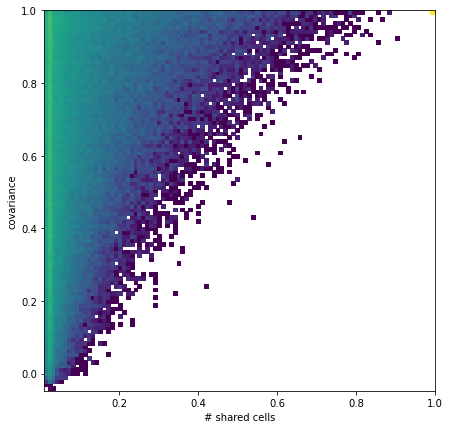

In [17]:
plt.rcParams["figure.figsize"] = [7,7]
plt.hist2d(
    (adj_mat.toarray()/tot_cells)[adj_mat.nonzero()],
#     adj_mat.toarray()[adj_mat.nonzero()],
#     sim_mat[adj_mat.nonzero()],
    cov_mat[adj_mat.nonzero()],
#     np.log1p(cov_mat[adj_mat.nonzero()]),
    bins=100, norm=matplotlib.colors.LogNorm()
);
plt.xlabel("# shared cells");
plt.ylabel("covariance");


In [19]:
zeros = np.where(sim_mat == 1)

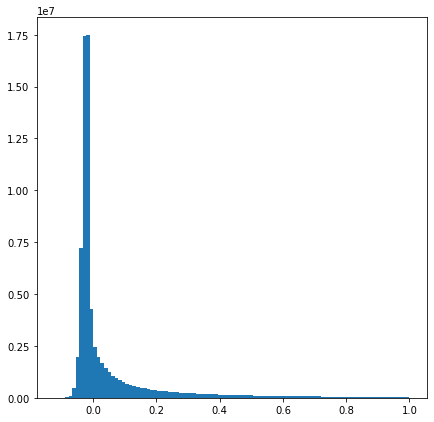

In [24]:
plt.hist(cov_mat[zeros],bins=100);

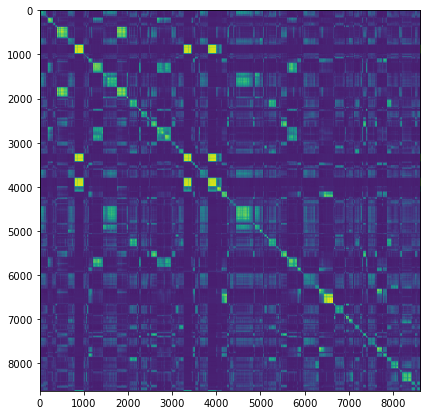

In [28]:
plt.imshow(cov_mat)

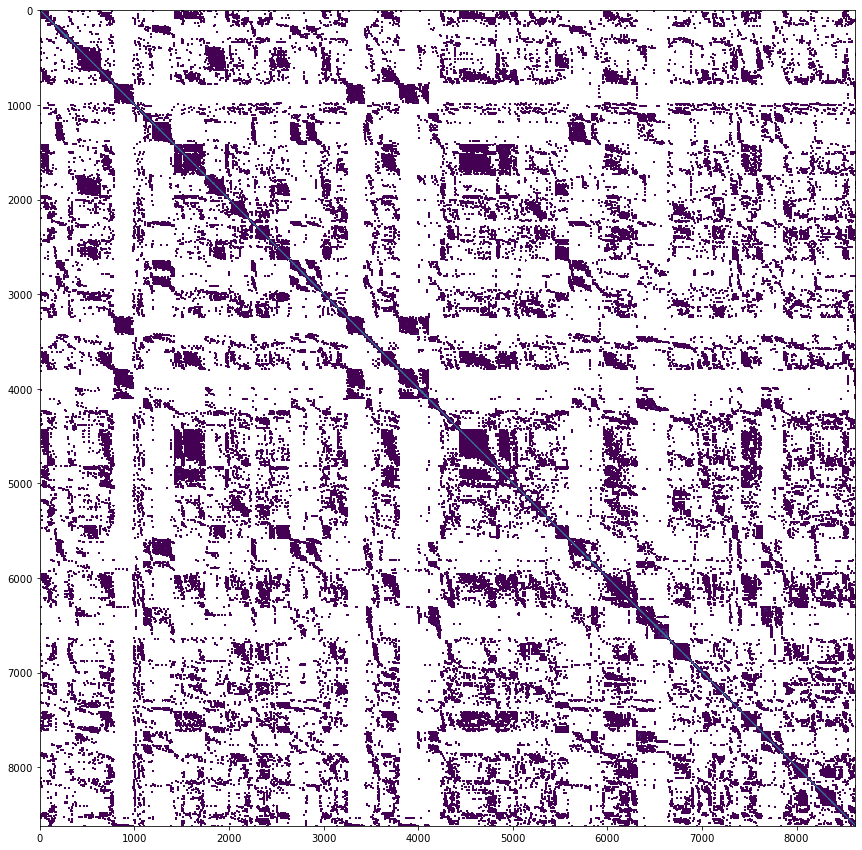

In [38]:
plt.rcParams["figure.figsize"] = [15,15]
plt.imshow(adj_mat.toarray()/tot_cells, norm=matplotlib.colors.LogNorm())

In [111]:
# frac_anno = pd.DataFrame(nhood_adata[keep_nhoods].obsm["frac_annotation"])
# frac_anno.columns = nhood_adata.uns["annotation_labels"]
# frac_anno

# from scipy.spatial import distance_matrix
# dist_anno = distance_matrix(frac_anno.values, frac_anno.values)

# is_anno = nhood_adata[keep_nhoods].obs["nhood_annotation"]=="CD4+T"

# anno_dummies = pd.get_dummies(nhood_adata[keep_nhoods].obs["nhood_annotation"])

# same_anno = anno_dummies.values.dot(anno_dummies.values.T)

# plt.rcParams["figure.figsize"] = [8,6]
# plt.hist(mat_2[same_anno!=1], bins=100, label="different annotation");
# # plt.hist(mat_2[same_anno.nonzero()], bins=100, label="same annotation");

# # plt.legend()

# plt.boxplot([mat_2[same_anno!=1], mat_2[same_anno.nonzero()]]);

In [205]:
def get_covariance(nhood_adata, org, alpha=0.1):
    ## Select nhoods where there is significant variation in time
    keep_nhoods = np.where((org_fdr_2["SpatialFDR_" + org] < alpha))
    li_nhood_adata = nhood_adata[keep_nhoods][:,nhood_adata.var["organ"] == org]

    X_mat = li_nhood_adata.X.toarray()
    cov_mat = np.corrcoef(X_mat)
    adj_mat = li_nhood_adata.obsp["nhood_connectivities"].copy()

#     sim_mat = 1/ (1 + (adj_mat.toarray()))
#     mat_2 = np.multiply(cov_mat, sim_mat)
    return(cov_mat)

def summarise_covariance(mat_2, org, alpha=0.1):
    keep_nhoods = np.where(org_fdr_2["SpatialFDR_" + org] < alpha)
    ## Summarise cov matrix by annotation pairs
    anno_dummies = pd.get_dummies(nhood_adata[keep_nhoods].obs["nhood_annotation"])
    n_annos = len(anno_dummies.columns)
    coarse_cov_df = pd.DataFrame(np.zeros(shape=[n_annos,n_annos]))
    coarse_cov_df.columns = anno_dummies.columns.copy()
    coarse_cov_df.index = anno_dummies.columns.copy()
#     coarse_sem_df = coarse_cov_df.copy()
    
    for a1 in anno_dummies.columns:
        for a2 in anno_dummies.columns:
            a_mean = mat_2[anno_dummies[a1]!=0,:][:,anno_dummies[a2]!=0].mean()
#             a_sem = scipy.stats.sem(mat_2[anno_dummies[a1]!=0,:][:,anno_dummies[a2]!=0].flatten())
            coarse_cov_df.loc[a1,a2] = a_mean
#             coarse_sem_df.loc[a1,a2] = a_sem
#     return(coarse_cov_df, coarse_sem_df)
    return(coarse_cov_df)

In [203]:
cov_BM = get_covariance(nhood_adata, "BM")
coarse_cov_BM = summarise_covariance(cov_BM, "BM")

In [206]:
cov_BM = get_covariance(nhood_adata, "BM", alpha=1)
coarse_cov_BM_nofilter = summarise_covariance(cov_BM, "BM", alpha=1)

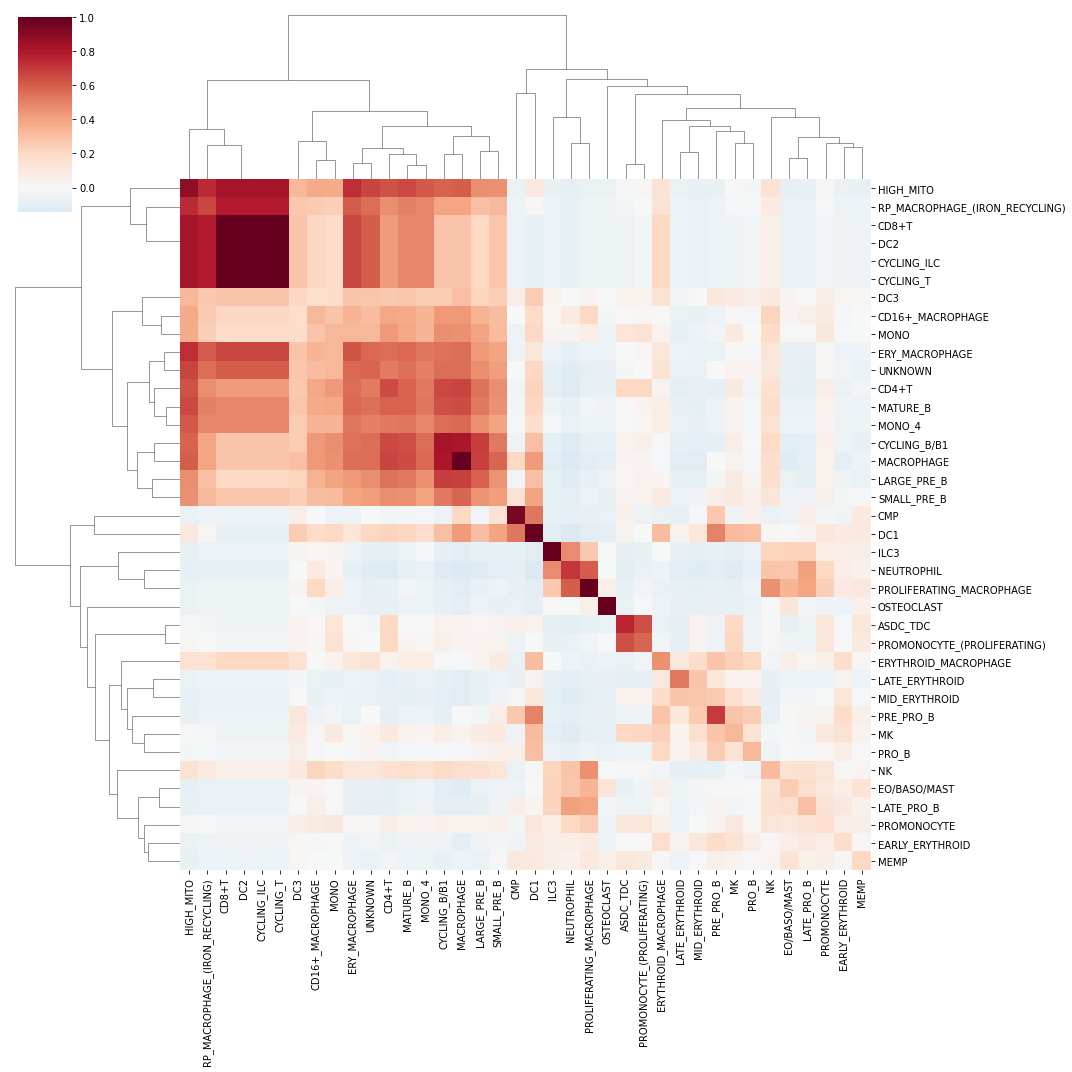

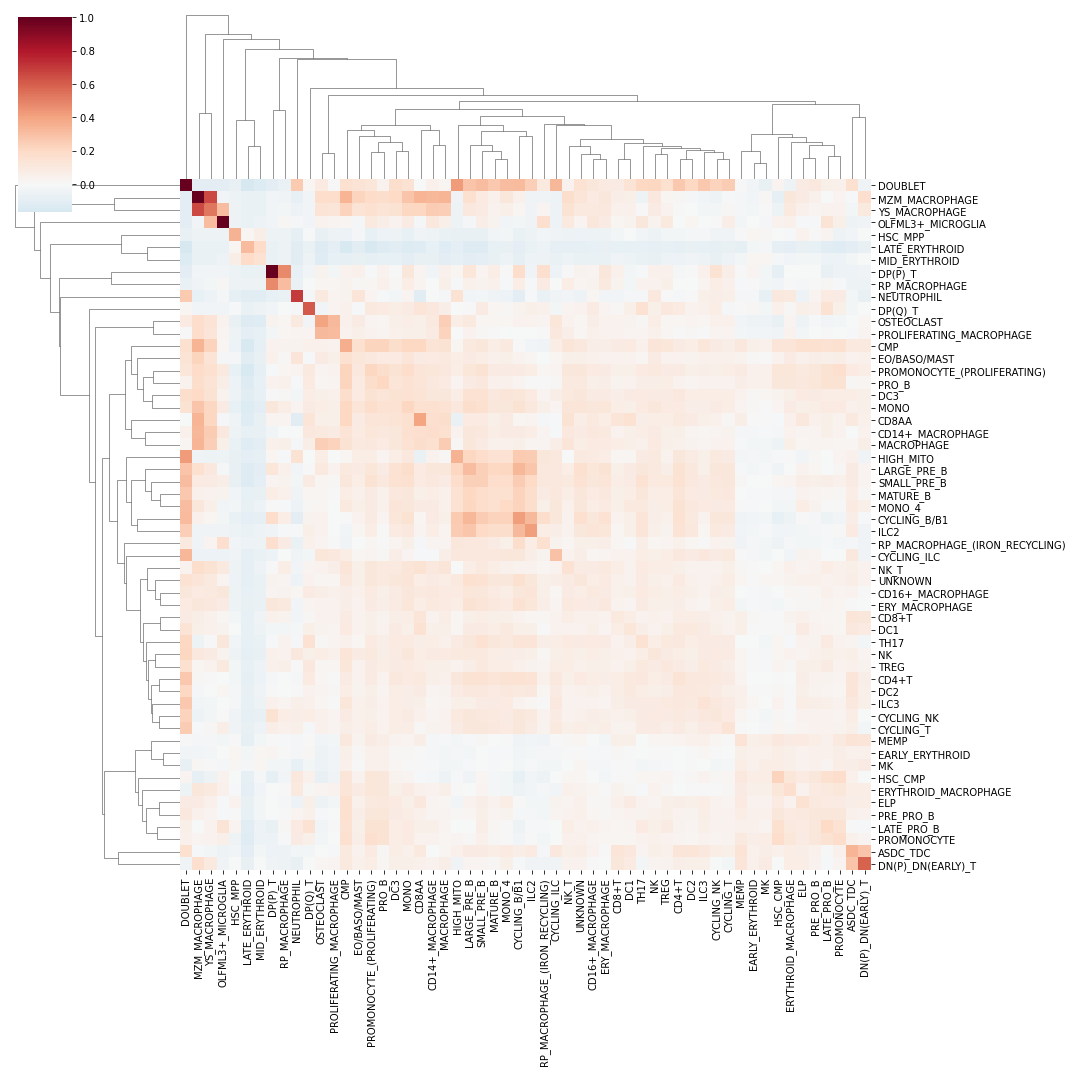

In [207]:
sns.clustermap(coarse_cov_BM, figsize=[15,15], center=0,cmap="RdBu_r")
sns.clustermap(coarse_cov_BM_nofilter, figsize=[15,15], center=0,cmap="RdBu_r")

In [212]:
cov_SP = get_covariance(nhood_adata, "SP")
coarse_cov_SP = summarise_covariance(cov_SP, "SP")

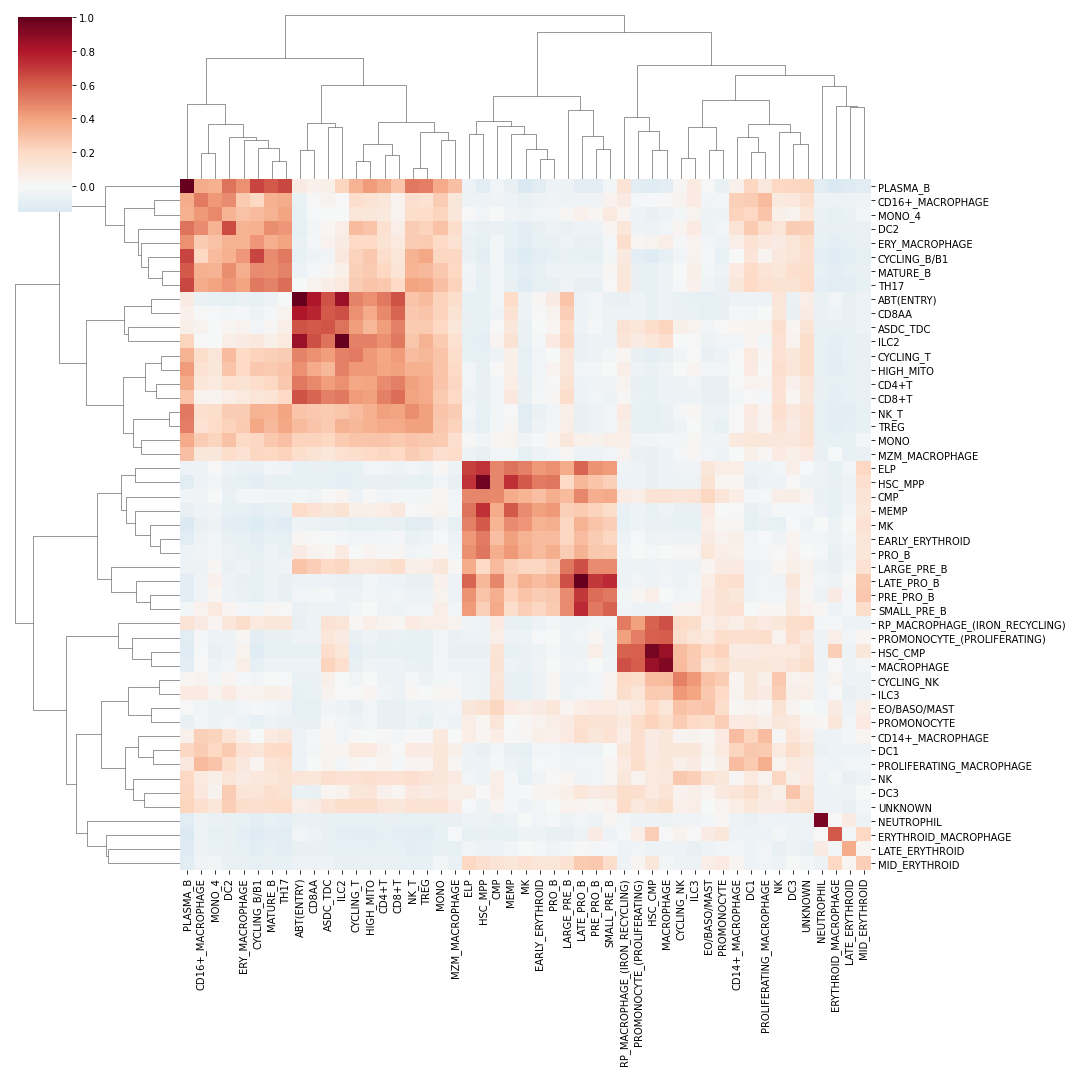

In [213]:
sns.clustermap(coarse_cov_SP, figsize=[15,15], center=0,cmap="RdBu_r")

In [210]:
cov_LI = get_covariance(nhood_adata, "LI")
coarse_cov_LI = summarise_covariance(cov_LI, "LI")

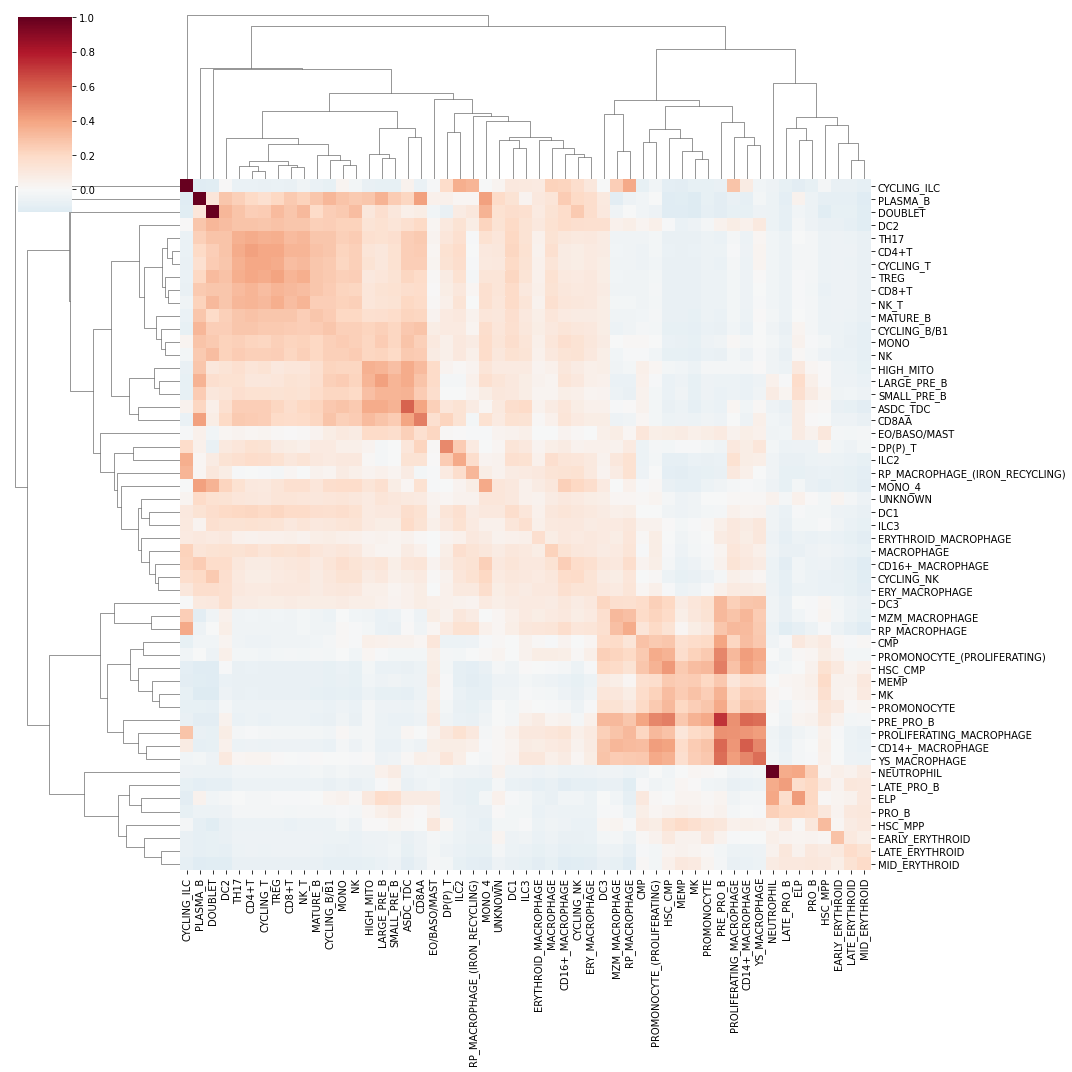

In [211]:
sns.clustermap(coarse_cov_LI, figsize=[15,15], center=0,cmap="RdBu_r")

In [197]:
cov_TH = get_covariance(nhood_adata, "TH")
coarse_cov_TH, coarse_sem_TH = summarise_covariance(cov_TH, "TH")

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/numpy/core/_methods.py:253: Ru

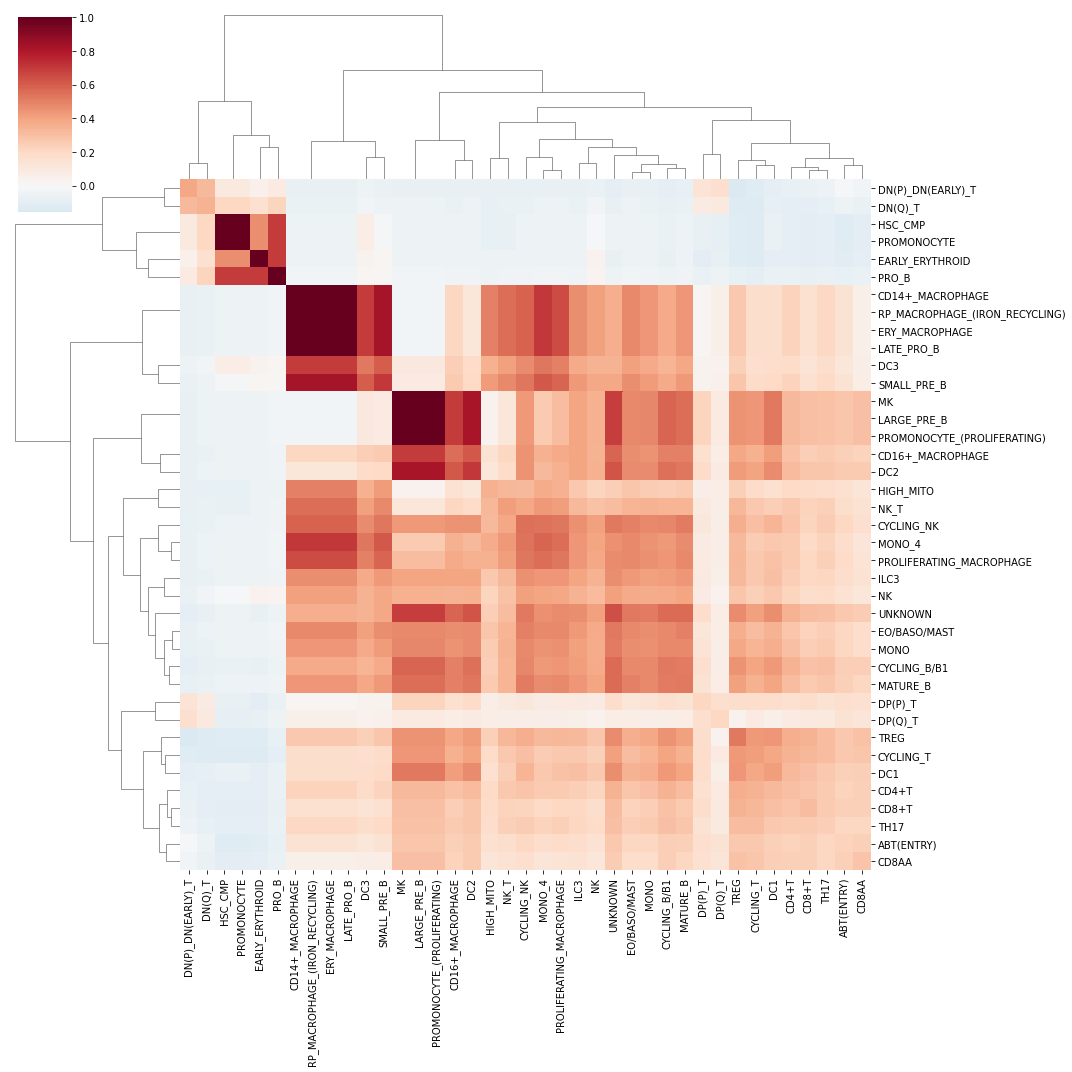

In [198]:
sns.clustermap(coarse_cov_TH, figsize=[15,15], center=0,cmap="RdBu_r")

### Compare between organs

<AxesSubplot:>

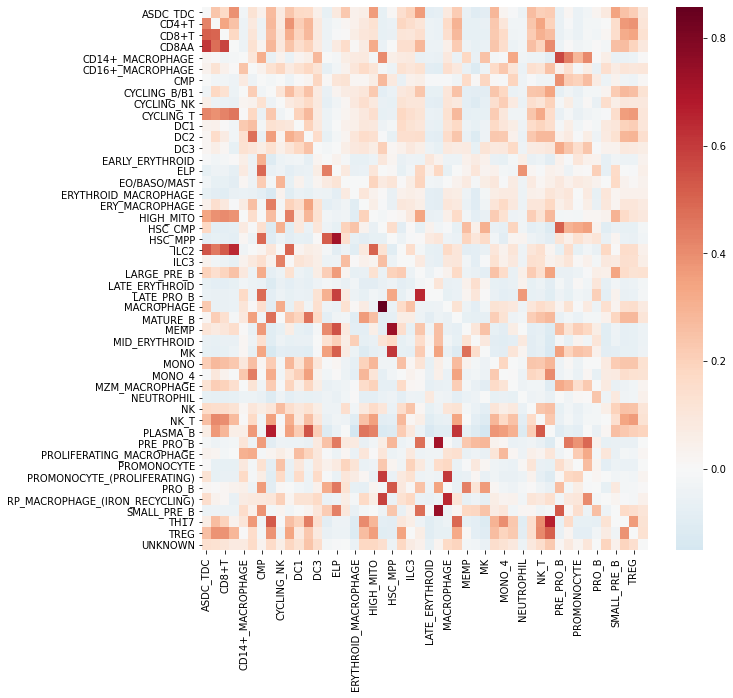

In [246]:
keep_cols = coarse_cov_SP.columns[coarse_cov_SP.columns.isin(coarse_cov_LI.columns)]

compare_cov = np.triu(coarse_cov_LI.loc[keep_cols,keep_cols], k=1) + np.tril(coarse_cov_SP.loc[keep_cols,keep_cols], k=-1)
compare_cov_df = pd.DataFrame(compare_cov)
compare_cov_df.columns = keep_cols
compare_cov_df.index = keep_cols

plt.rcParams["figure.figsize"] = [10,10] 
sns.heatmap(compare_cov_df,center=0,cmap="RdBu_r")